### Función Multiobjetivo

Minimizar riesgo:
$$w\cdot \Sigma \cdot w^T = \sigma^2$$

Maximizar retorno:
$$\mu \cdot w^T$$

Para ello teneoms el siguiente código en python donde usamos la librería [PyPortfolioOpt](https://pyportfolioopt.readthedocs.io/en/latest/UserGuide.html) y usamos la base de datos de yahoo finance para obtener los datos históricos de las empresas y acciones

In [610]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import seaborn as sns
from pypfopt import EfficientFrontier, risk_models, expected_returns, plotting

Insertamos nuestros tickers (Códigos de empresas a invertir) y la fecha a partir de la cual tomaremos nuestros datos

In [611]:
tickers = ["AAPL", "MSFT","AMZN","GOOGL","TSLA","V"]
start_date = '2016-04-20'

Obtenemos nuestros precios de cierre diario de nuestros tickers y mostramos sus gráficas

[*********************100%***********************]  6 of 6 completed

Precios


Ticker,AAPL,AMZN,GOOGL,MSFT,TSLA,V
Date,,,,,,
2016-04-20,24.395393,31.649500,38.606052,49.485168,16.664667,76.491646
2016-04-21,24.131237,31.549999,38.859131,49.654305,16.552668,76.152298
2016-04-22,24.065207,31.025000,36.755260,46.093582,16.916668,74.568756
2016-04-25,23.928568,31.309999,36.976456,46.387356,16.788000,73.654427
2016-04-26,23.762335,30.844000,36.137501,45.790920,16.916000,74.022064
...,...,...,...,...,...,...
2024-12-24,258.200012,229.050003,196.110001,439.329987,462.279999,320.649994
2024-12-26,259.019989,227.050003,195.600006,438.109985,454.130005,320.910004
2024-12-27,255.589996,223.750000,192.759995,430.529999,431.660004,318.660004


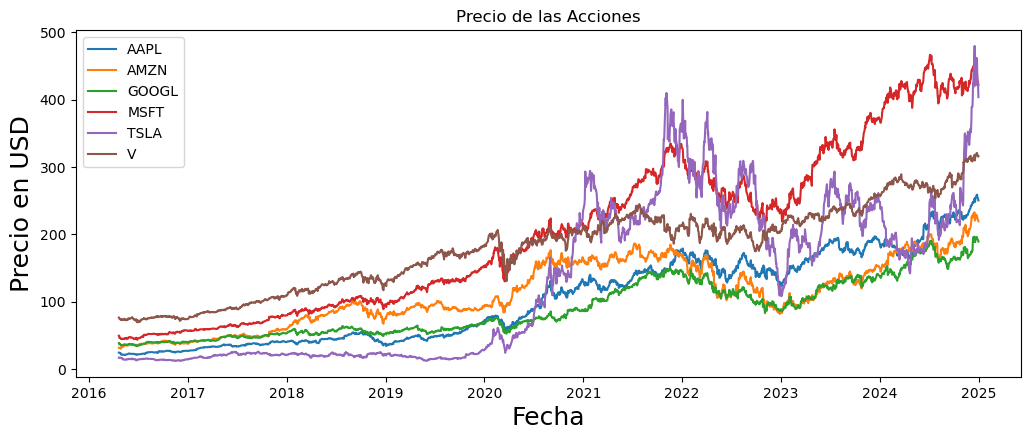

In [612]:
prices = yf.download(tickers , start=start_date)['Close']
print("Precios")
display(prices)
plt.figure(figsize=(12.2,4.5)) 
for i in prices.columns.values:
    plt.plot( prices[i],  label=i)
plt.title('Precio de las Acciones')
plt.xlabel('Fecha',fontsize=18)
plt.ylabel('Precio en USD',fontsize=18)
plt.legend(prices.columns.values, loc='upper left')
plt.savefig('plotprecios.png', dpi=300, bbox_inches='tight')
plt.show()

Calculamos nuestro vector $\mu$ de retornos esperados y la matriz de covarianza $\Sigma$

In [613]:

mean_returns = expected_returns.mean_historical_return(prices)
cov_matrix = risk_models.sample_cov(prices)
print("Retornos esperados")
print(mean_returns)

Retornos esperados
Ticker
AAPL     0.307462
AMZN     0.249682
GOOGL    0.200855
MSFT     0.279675
TSLA     0.443361
V        0.177500
dtype: float64


Función para mostrar nuestra frontera eficiente

In [614]:
def plot_efficient_frontier(mean_returns, cov_matrix):
    ef = EfficientFrontier(mean_returns, cov_matrix , weight_bounds=(0,1))
    fig, ax = plt.subplots(figsize=(10, 6))
    plotting.plot_efficient_frontier(ef, ax=ax, show_assets=True)
    
    for i, asset in enumerate(mean_returns.index):
        asset_return = mean_returns[asset]
        asset_volatility = np.sqrt(cov_matrix.loc[asset, asset])  # Desviación estándar del activo
        ax.annotate(asset, 
            (asset_volatility, asset_return),
            textcoords="offset points",
            xytext=(0, 10),  # Ajuste de desplazamiento de texto
            ha='center', 
            fontsize=9, 
            color='black')


    plt.title("Frontera Eficiente")
    plt.xlabel("Riesgo (Desviación Estándar)")
    plt.ylabel("Retorno Esperado")
    plt.show()

Calulamos nuestra frontera eficiente y obtenemos los pesos óptimos con una mínima volatilidad y mostramos el resultado, veamos que si existe algún activo de alta volatilidad no se invertirá en él 

El Sharpe Ratio es una medida utilizada en finanzas para evaluar el rendimiento ajustado por riesgo de una inversión o portafolio. Fue desarrollado por el economista William F. Sharpe y se utiliza principalmente para determinar si el rendimiento de una inversión es adecuado en relación con el riesgo que se ha asumido.

- Sharpe Ratio > 1: Excelente rendimiento ajustado al riesgo.
- Sharpe Ratio ≈ 0.5 - 1: Moderado rendimiento ajustado al riesgo.
- Sharpe Ratio < 0.5: Bajo rendimiento ajustado al riesgo.
- Sharpe Ratio negativo: La inversión está rindiendo por debajo de la tasa libre de riesgo.

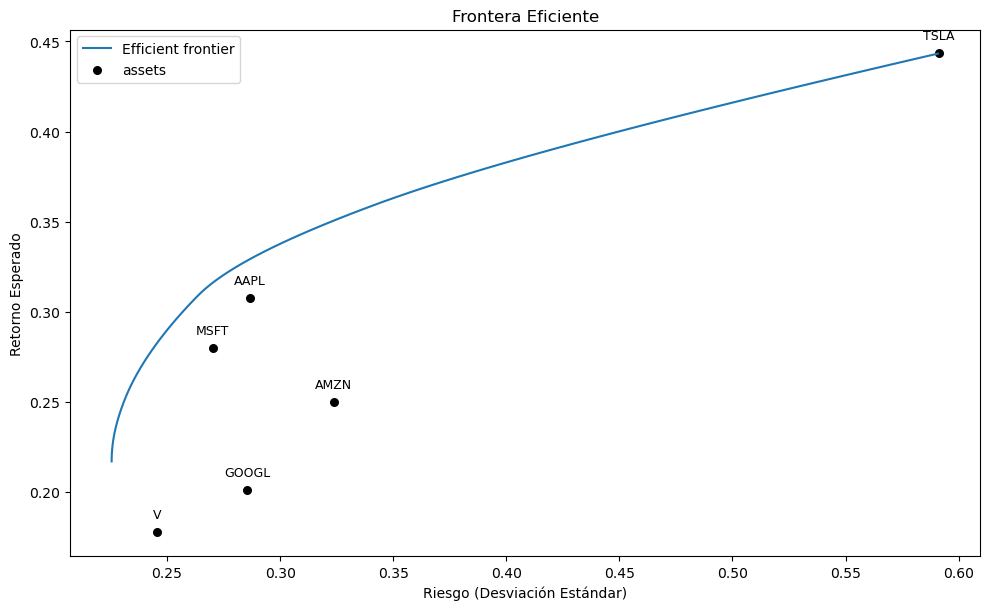

{'AAPL': '15.0%', 'AMZN': '9.0%', 'GOOGL': '13.0%', 'MSFT': '10.0%', 'TSLA': '0.0%', 'V': '53.0%'}
 
Expected annual return: 21.7%
Annual volatility: 22.5%
Sharpe Ratio: 0.96


(0.21685787914737578, 0.22546417721086814, 0.9618285344928954)

In [615]:
ef = EfficientFrontier(mean_returns, cov_matrix , weight_bounds=(0,1))
weights = ef.min_volatility()
cleaned_weights = ef.clean_weights() 
cleaned_weights_percentage = {k: f"{round(v * 100 ,0)}%" for k, v in cleaned_weights.items()}
plot_efficient_frontier(mean_returns , cov_matrix)

print(cleaned_weights_percentage)
print(" ")
ef.portfolio_performance(verbose=True)


Obtengamos ahora nuestros pesos óptimos respecto a maximizar el Sharpe Ratio

In [616]:
ef = EfficientFrontier(mean_returns, cov_matrix , weight_bounds=(0,1))
weights = ef.max_sharpe()
cleaned_weights = ef.clean_weights() 
cleaned_weights_percentage = {k: f"{round(v * 100 ,0)}%" for k, v in cleaned_weights.items()}
print(cleaned_weights_percentage)
print(" ")
ef.portfolio_performance(verbose=True)

{'AAPL': '48.0%', 'AMZN': '0.0%', 'GOOGL': '0.0%', 'MSFT': '41.0%', 'TSLA': '11.0%', 'V': '0.0%'}
 
Expected annual return: 31.1%
Annual volatility: 26.5%
Sharpe Ratio: 1.17


(0.31083212676693256, 0.2652165761912779, 1.1719935881487138)

Veamos que en este caso aumentó el retorno anual y el Sharpe Ratio, pero también aumenta la volatilidad. 